In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, plot
from cellpose.io import imread
from skimage.io import imsave

io.logger_setup()

creating new log file
2025-04-30 14:04:06,783 [INFO] WRITING LOG OUTPUT TO C:\Users\Habin\.cellpose\run.log
2025-04-30 14:04:06,783 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	win32 
python version: 	3.9.21 
torch version:  	2.7.0+cu128


(<Logger cellpose.io (INFO)>, WindowsPath('C:/Users/Habin/.cellpose/run.log'))

In [2]:
# USER INPUTS
# Paths
pth_imgs = r'\\shelter.win.ad.jhu.edu\Kyu\Habin\cropping_brain_test'                     # path to input directory with the images to crop
pth_masks = r'\\shelter.win.ad.jhu.edu\Kyu\Habin\cropping_brain_test\masks'              # path to output directory for cropped downscaled masks
pth_overlaid = r'\\shelter.win.ad.jhu.edu\Kyu\Habin\cropping_brain_test\overlaid_masks'  # path to output directory for cropped downscaled overlaid masks

# Input parameters
img_exts = (".tif", ".tiff") # tuple containing valid image extensions

# Downscale factor (Aim for less than 150 px cell diameter for higher accuracy and speed for cellpose)
downscale_factor = 1 / 20

# Visualize n images and apply to these first
n = 5

# Cellpose parameters
model_type = "cyto3"
channels = [0,0]            # first and second channels (grayscale=0, R=1, G=2, B=3)
diameter = 130              # cell diameter in pixels (most important to adjust)
cellprob_threshold = -1     # set lower to increase boundary and higher to decrease boundary (range is -6 to 6)

In [3]:
# Create paths if they don't exist
os.makedirs(pth_masks, exist_ok=True)
os.makedirs(pth_overlaid, exist_ok=True)

In [4]:
# Read images
img_files = [os.path.join(pth_imgs, f) for f in os.listdir(pth_imgs) if f.lower().endswith(img_exts)]
img_names = [os.path.basename(f) for f in img_files]
imgs = [imread(f) for f in img_files]
print(f"Found {len(imgs)} images")

Found 18 images


In [5]:
# Downscale the images for more accurate and faster prediction by cellpose
print(f"Original image shape: {imgs[0].shape}")
imgs = [cv2.resize(img, (0, 0), fx=downscale_factor, fy=downscale_factor, interpolation=cv2.INTER_AREA) for img in imgs]
print(f"Downscaled image shape: {imgs[0].shape}")

Original image shape: (4664, 12718, 3)
Downscaled image shape: (233, 636, 3)


In [6]:
# Configure model
model = models.Cellpose(model_type=model_type, gpu=True)

2025-04-30 14:04:36,576 [INFO] ** TORCH CUDA version installed and working. **
2025-04-30 14:04:36,576 [INFO] >>>> using GPU (CUDA)
2025-04-30 14:04:36,576 [INFO] >> cyto3 << model set to be used
2025-04-30 14:04:36,655 [INFO] >>>> loading model C:\Users\Habin\.cellpose\models\cyto3
2025-04-30 14:04:36,709 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


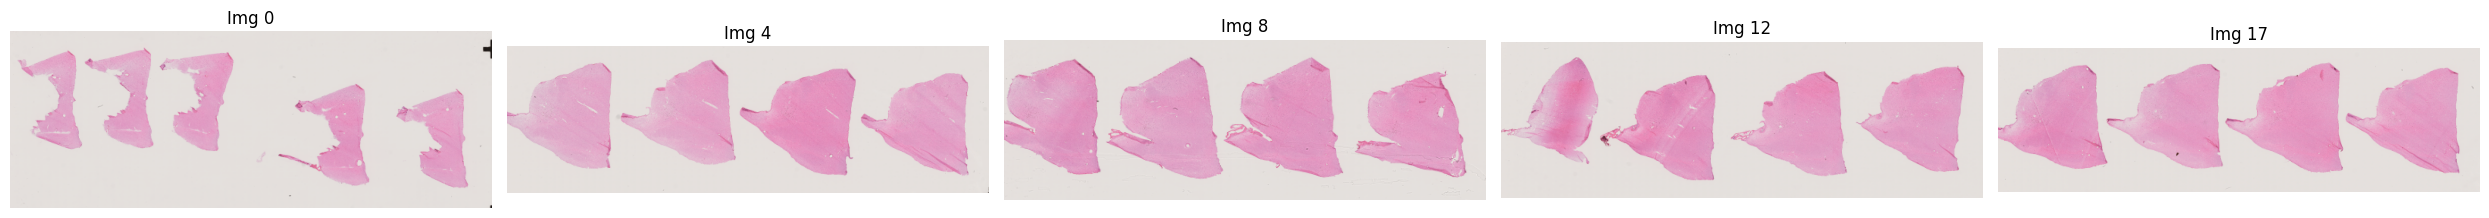

2025-04-30 14:04:36,910 [INFO] channels set to [0, 0]
2025-04-30 14:04:36,910 [INFO] ~~~ FINDING MASKS ~~~
2025-04-30 14:04:39,159 [INFO] 100%|##########| 5/5 [00:02<00:00,  2.22it/s]
2025-04-30 14:04:39,159 [INFO] >>>> TOTAL TIME 2.25 sec


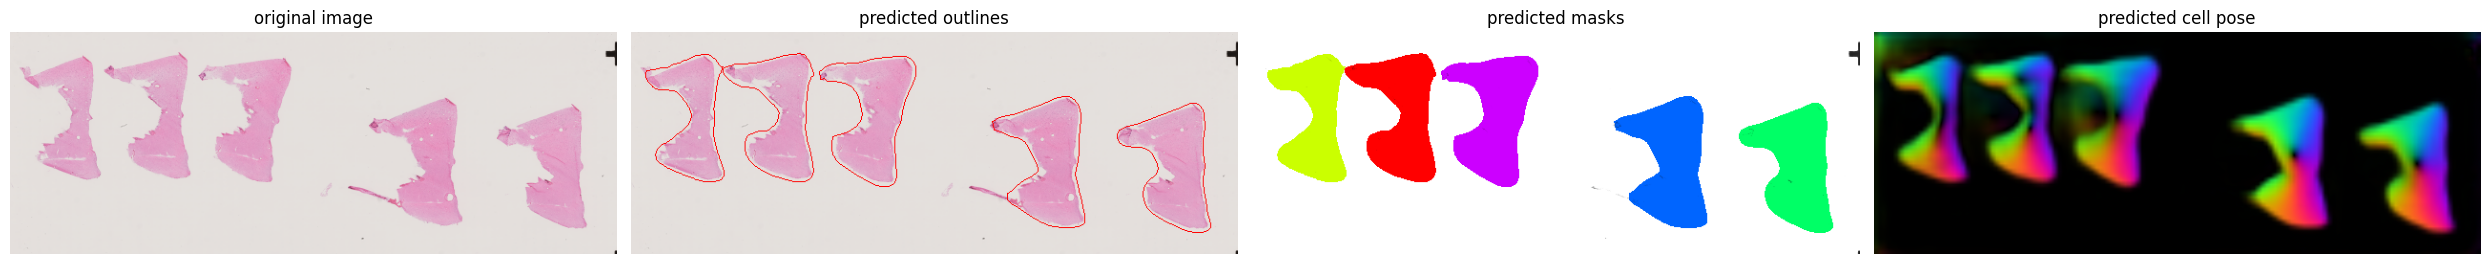

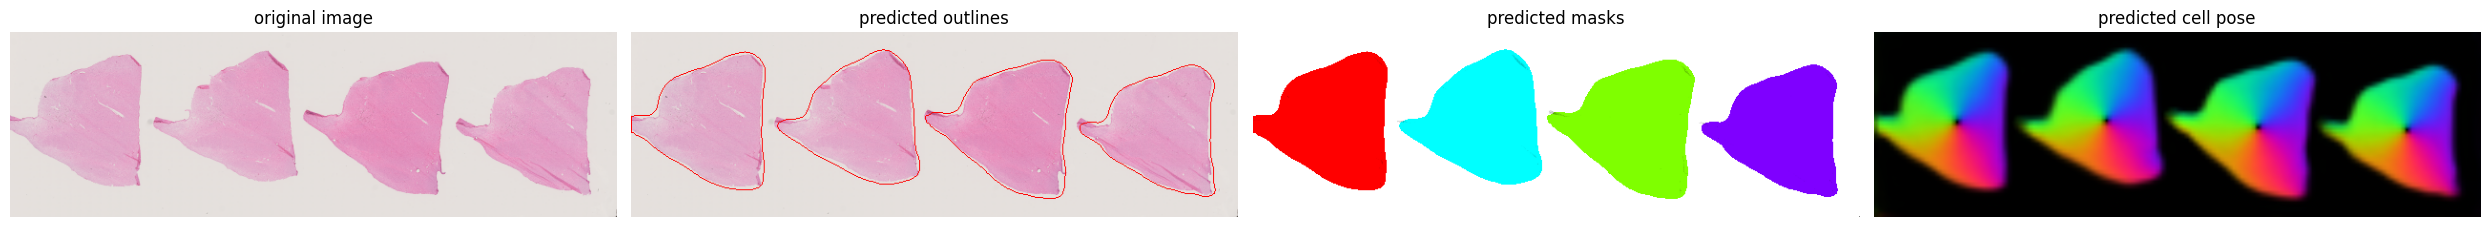

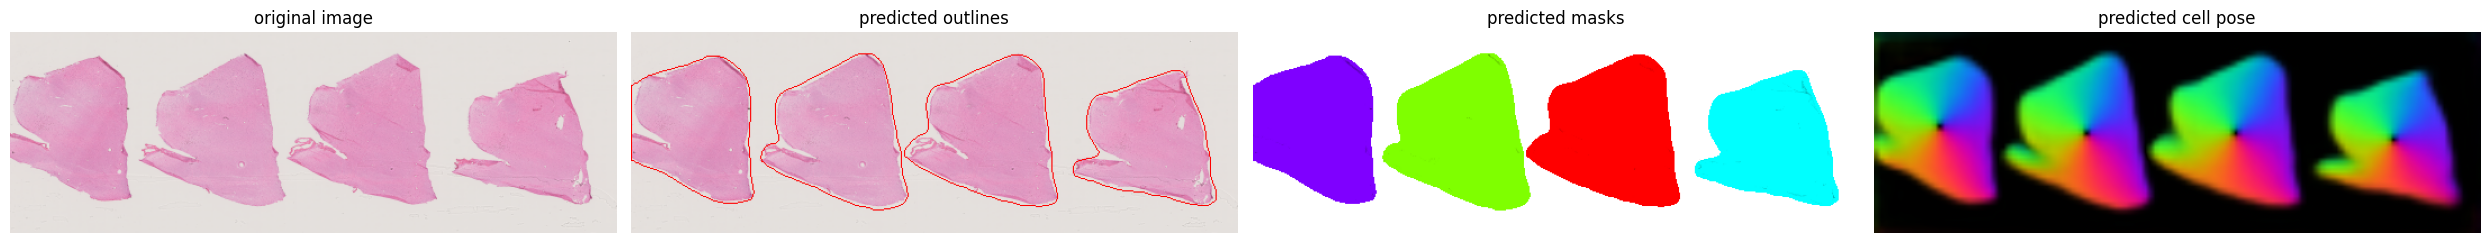

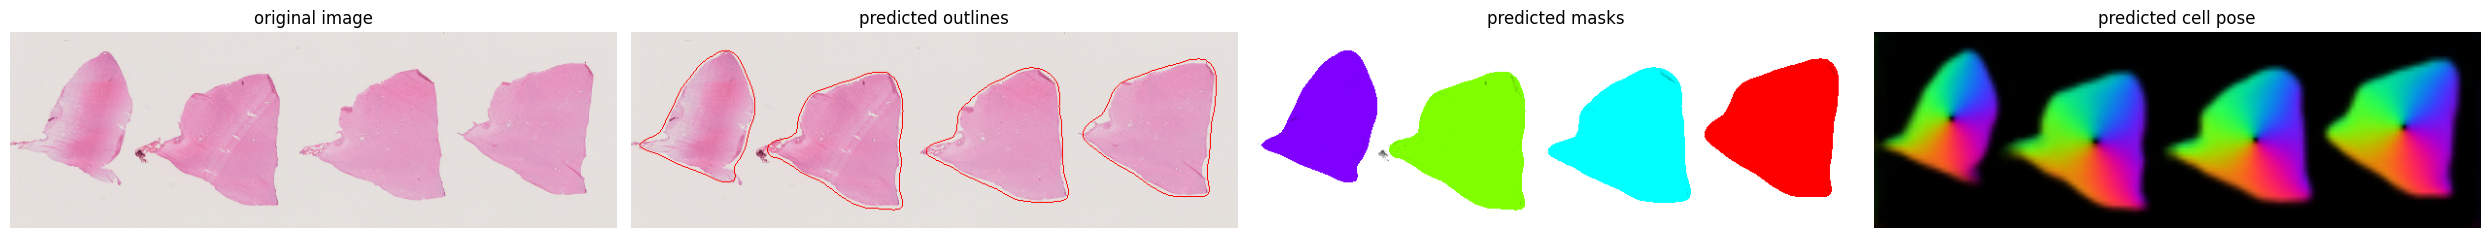

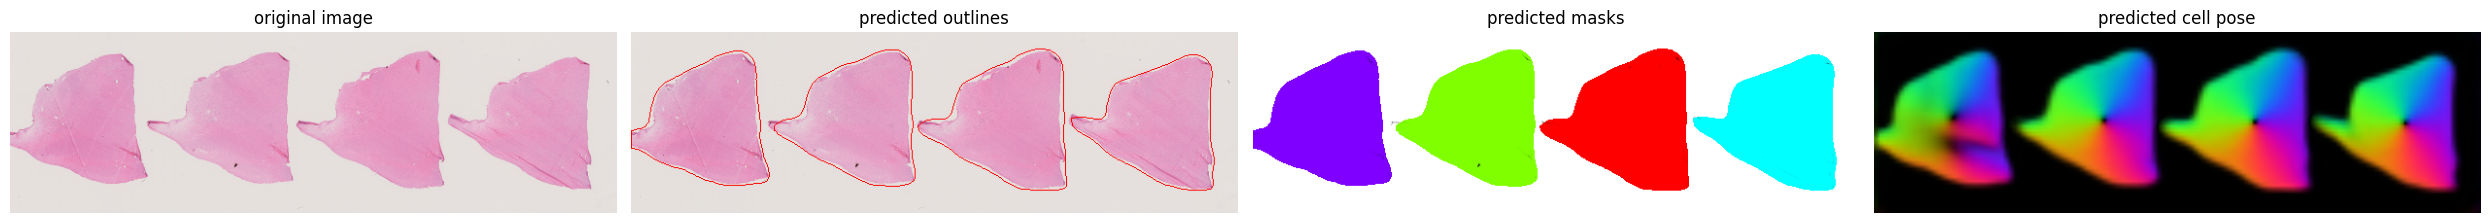

In [7]:
# TRY IT ON FEW IMAGES TO CHECK OPTIMAL CELLPOSE PARAMETERS
# Subset n evenly interspersed images
indices = np.linspace(0, len(imgs) - 1, n, dtype=int)
subset_imgs = [imgs[i] for i in indices]

# Visualize the subset images
plt.figure(figsize=(5 * n, 2 * n))

for i, img in enumerate(subset_imgs):
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Img {indices[i]}')  # Still show the original index for reference

plt.tight_layout()
plt.show()

# Run the model on the subset images
masks, flows, styles, diams = model.eval(subset_imgs, channels=channels, diameter=diameter, cellprob_threshold=cellprob_threshold)

# Visualize the output of the model on the subset images
for i in range(len(subset_imgs)):
    fig = plt.figure(figsize=(5 * n, 2 * n))
    plot.show_segmentation(fig, subset_imgs[i], masks[i], flows[i][0], channels=channels[0])
    plt.tight_layout()
    plt.show()


In [8]:
# APPLY TO ALL IMAGES
# Run the model on all images
masks, flows, styles, diams = model.eval(imgs, channels=channels, diameter=diameter, cellprob_threshold=cellprob_threshold)

# Save masks
io.save_masks(imgs, masks, flows, img_names, png=False, tif=True, savedir=pth_masks)

# Save overlaid masks
for i in range(len(imgs)):
    overlay = plot.mask_overlay(imgs[i], masks[i], colors=None)  # returns RGB overlay

    # Blend overlay and image
    alpha = 0.25
    blended = (alpha * overlay.astype(np.float32) +
               (1 - alpha) * imgs[i].astype(np.float32)).astype(np.uint8)

    # Save as TIFF
    save_path = os.path.join(pth_overlaid, os.path.splitext(img_names[i])[0] + "_overlay.tif")
    imsave(save_path, blended)

2025-04-30 14:04:39,981 [INFO] channels set to [0, 0]
2025-04-30 14:04:39,981 [INFO] ~~~ FINDING MASKS ~~~
2025-04-30 14:04:43,664 [INFO] 100%|##########| 18/18 [00:03<00:00,  4.89it/s]
2025-04-30 14:04:43,664 [INFO] >>>> TOTAL TIME 3.68 sec
